In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16131292019847417559, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15703311680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4048073663310708961
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
from PIL import Image
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('./drive/MyDrive/A.papis')

In [ ]:
import pickle
x_test=pickle.load(open('x_test.pickle','rb'))

In [ ]:
print(x_test.shape)

(48, 256, 256, 3)


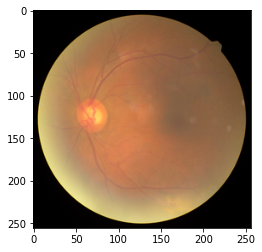

In [ ]:
plt.imshow(x_test[0])

In [ ]:
import pickle
x=pickle.load(open('x1.pickle','rb'))
y=pickle.load(open('y_disc.pickle','rb'))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)
y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],y_train.shape[2],1))
y_val = y_val.reshape((y_val.shape[0],y_val.shape[1],y_val.shape[2],1))
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (200, 256, 256, 3)
y_train:  (200, 256, 256, 1)
x_val:  (200, 256, 256, 3)
y_val:  (200, 256, 256, 1)


In [ ]:
def plot_imgs(org_imgs, 
              mask_imgs, 
              pred_imgs=None, 
              nm_img_to_plot=10, 
              figsize=4,
              alpha=0.5
             ):
    '''
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    '''
    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if  not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

        
    fig, axes = plt.subplots(nm_img_to_plot, cols, figsize=(cols*figsize, nm_img_to_plot*figsize))
    axes[0, 0].set_title("original", fontsize=15) 
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15) 
        axes[0, 3].set_title("overlay", fontsize=15) 
    else:
        axes[0, 2].set_title("overlay", fontsize=15) 
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()        
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(mask_to_red(zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size)), cmap=get_cmap(pred_imgs), alpha=alpha)
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(mask_to_red(zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size)), cmap=get_cmap(mask_imgs), alpha=alpha)
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()

def reshape_arr(arr):
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])

def get_cmap(arr):
    if arr.ndim == 3:
        return 'gray'
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return 'jet'
        elif arr.shape[3] == 1:
            return 'gray'

def mask_to_red(mask):
    '''
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    '''
    img_size = mask.shape[0]
    c1 = mask.reshape(img_size,img_size)
    c2 = np.zeros((img_size,img_size))
    c3 = np.zeros((img_size,img_size))
    c4 = mask.reshape(img_size,img_size)
    return np.stack((c1, c2, c3, c4), axis=-1)

def zero_pad_mask(mask, desired_size):
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask    

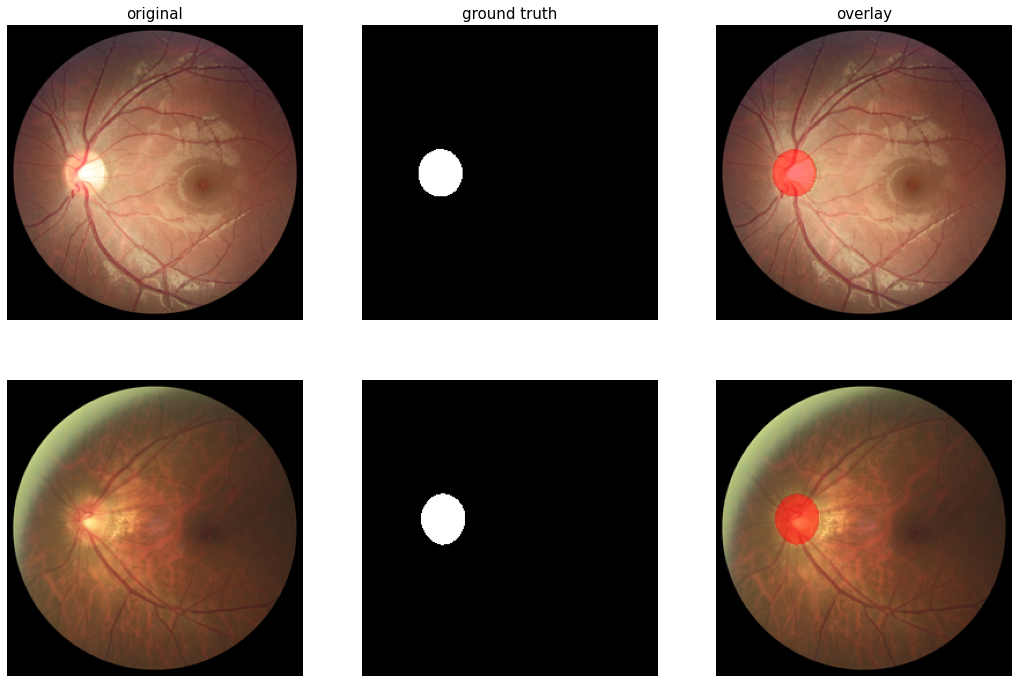

In [ ]:
plot_imgs(org_imgs=x, mask_imgs=y, nm_img_to_plot=2, figsize=6)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def get_augmented(
    X_train, 
    Y_train, 
    X_val=None,
    Y_val=None,
    batch_size=16, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        #width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        #zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    )):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
        Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)
        
        return train_generator, val_generator
    else:
        return train_generator

In [ ]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.01,
        zoom_range=(0.8, 1.2),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval=0.0
    ))

In [ ]:
sample_batch = next(train_gen)
xx, yy = sample_batch

In [ ]:
print(xx.shape, yy.shape)

(2, 256, 256, 3) (2, 256, 256, 1)


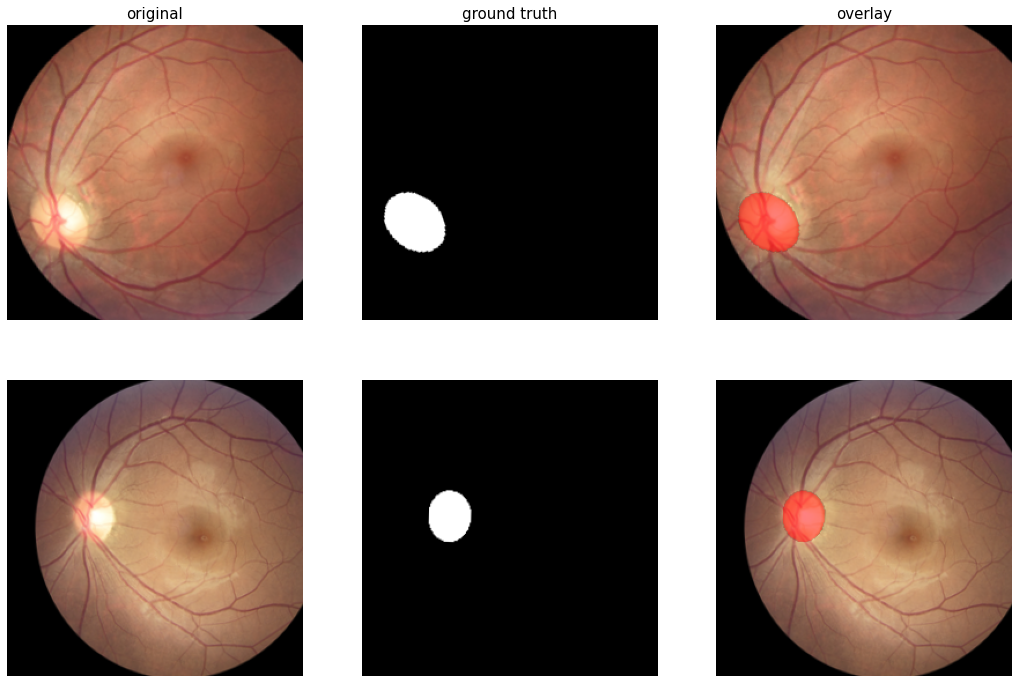

In [ ]:
plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, average

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

def conv2d_block(
    inputs, 
    use_batch_norm=True, 
    dropout=0.3, 
    filters=16, 
    kernel_size=(3,3), 
    activation='relu', 
    kernel_initializer='he_normal', 
    padding='same'):
    
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

def unet_model(
    input_shape,
    num_classes=1,
    use_batch_norm=True, 
    upsample_mode='deconv', # 'deconv' or 'simple' 
    use_dropout_on_upsampling=False, 
    dropout=0.3, 
    dropout_change_per_layer=0.0,
    filters=16,
    num_layers=4,
    output_activation='sigmoid'): # 'sigmoid' or 'softmax'
    
    if upsample_mode=='deconv':
        upsample=upsample_conv
    else:
        upsample=upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs   

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
        down_layers.append(x)
        x = MaxPooling2D((2, 2)) (x)
        dropout += dropout_change_per_layer
        filters = filters*2 # double the number of filters with each layer

    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):        
        filters //= 2 # decreasing number of filters with each layer 
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding='same') (x)
        x = concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
    
    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
input_shape = x_train[0].shape

In [ ]:
model = unet_model(
    input_shape,
    num_classes=1,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid'
)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf


def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

    
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)


def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y


def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
model.compile(
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou_thresholded]
)

In [ ]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=25,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
100/100 [==============================] - 53s 198ms/step - loss: 0.3310 - dice_coef: 0.2768 - iou_thresholded: 0.3261 - val_loss: 0.2190 - val_dice_coef: 0.3816 - val_iou_thresholded: 0.2426
Epoch 2/25
100/100 [==============================] - 9s 94ms/step - loss: 0.0146 - dice_coef: 0.8572 - iou_thresholded: 0.7941 - val_loss: 0.3096 - val_dice_coef: 0.3965 - val_iou_thresholded: 0.2511
Epoch 3/25
100/100 [==============================] - 9s 94ms/step - loss: 0.0095 - dice_coef: 0.8854 - iou_thresholded: 0.8297 - val_loss: 0.1416 - val_dice_coef: 0.4486 - val_iou_thresholded: 0.3003
Epoch 4/25
100/100 [==============================] - 9s 95ms/step - loss: 0.0074 - dice_coef: 0.8949 - iou_thresholded: 0.8595 - val_loss: 0.0425 - val_dice_coef: 0.6268 - val_iou_thresholded: 0.5446
Epoch 5/25
100/100 [==============================] - 10s 95ms/step - loss: 0.0076 - dice_coef: 0.8934 - iou_thresholded: 0.8538 - val_loss: 0.0187 - val_dice_coef: 0.7414 - val_iou_thresholded:

In [ ]:
y_pred = model.predict(x_val)

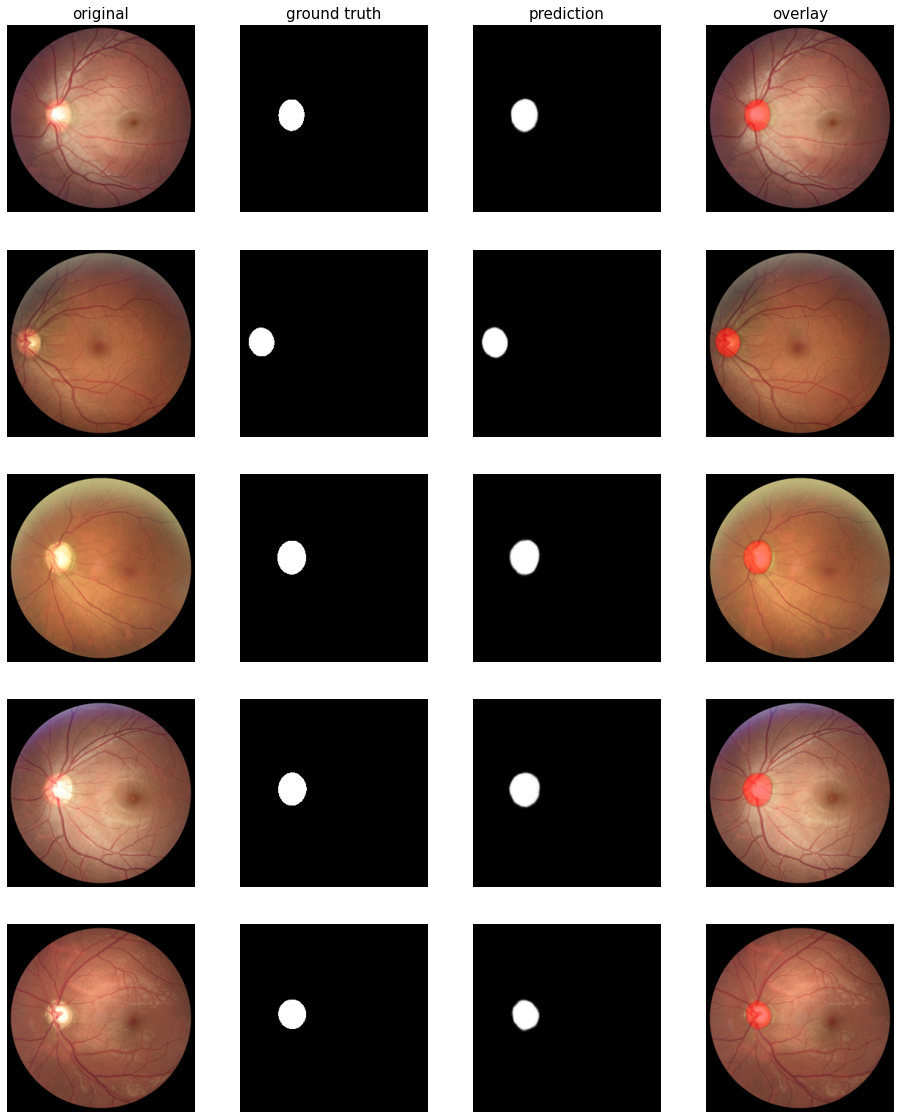

In [ ]:
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=5)

In [ ]:
yp = model.predict(x=x_val, batch_size=4, verbose=1)
yp = np.round(yp,0)
yp = np.squeeze(yp)

50/50 [==============================] - 4s 39ms/step


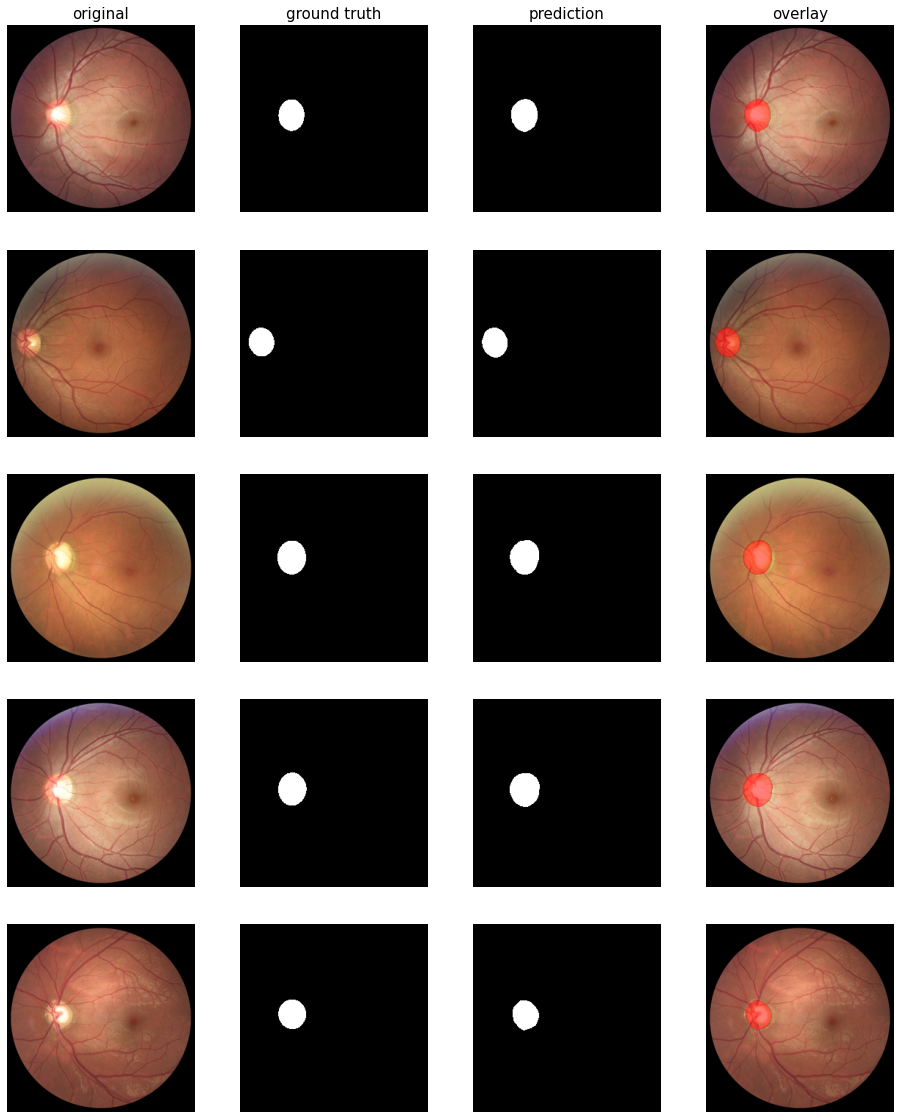

In [ ]:
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=yp, nm_img_to_plot=5)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred_img = np.squeeze(y_pred)

In [ ]:
a=['001L (2).jpg', '001R (2).jpg', '002L (2).jpg', '002R (2).jpg', '003R (2).jpg', '004L (2).jpg', '004R (2).jpg', '005L (2).jpg', '005R (2).jpg', '006L (2).jpg', '006R (2).jpg', '008L (2).jpg', '008R (2).jpg', '009L (2).jpg', '009R (2).jpg', '010L (2).jpg', '010R (2).jpg', '011L (2).jpg', '011R (2).jpg', '012L (2).jpg', '012R (2).jpg', '013L (2).jpg', '013R (2).jpg', '014L (2).jpg', '014R (2).jpg', '015L (2).jpg', '015R (2).jpg', '016L (2).jpg', '016R (2).jpg', '017L (2).jpg', '017R (2).jpg', '018L (2).jpg', '018R (2).jpg', '019L (2).jpg', '019R (2).jpg', '020L (2).jpg', '021R (2).jpg', '022L (2).jpg', '022R (4).jpg', '023L (2).jpg', '023R (2).jpg', '024L (2).jpg', '024R (2).jpg', '025L (2).jpg', '025R (2).jpg', '026L (2).jpg', '026R (2).jpg', '027L (2).jpg']

In [ ]:
b=[]
for i in range(len(a)):
  name, ext = a[i].split('.')
  b.append(name)
b[0]

'001L (2)'

In [ ]:
print(len(b))
print(len(x_test))

48
48


In [ ]:
def img(i):
  plt.figure(figsize=(20,20))

  plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


  plt.subplot(3,3,1)
  plt.title("original",size=25)
  plt.imshow(x_test[i])
  plt.axis('off')
  


  plt.subplot(3,3,2)
  plt.title("prediction",size=25)
  plt.imshow(y_pred_img[i],cmap='gray')
  plt.axis('off')


  


  plt.subplot(3,3,3)
  plt.title("overlay",size=25)
  plt.imshow(x_test[i], cmap=get_cmap(x_test))
  plt.imshow(mask_to_red(zero_pad_mask(y_pred_img[i], desired_size=256)), cmap=get_cmap(y_pred_img), alpha=0.5)
  plt.axis('off')
  



  #plt.savefig('predict_img_siri/{0}.jpg'.format(b[i]))

In [ ]:
for i in range(len(x_test)):
  img(i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
preds_test = model.predict(x_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_t=np.squeeze(preds_test_t)

2/2 [==============================] - 0s 335ms/step


In [ ]:
def img(i):
  plt.figure(figsize=(20,20))

  plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


  plt.subplot(3,3,1)
  plt.title("original",size=25)
  plt.imshow(x_test[i])
  plt.axis('off')
  


  plt.subplot(3,3,2)
  plt.title("prediction",size=25)
  plt.imshow(preds_test_t[i],cmap='gray')
  plt.axis('off')


  


  plt.subplot(3,3,3)
  plt.title("overlay",size=25)
  plt.imshow(x_test[i], cmap=get_cmap(x_test))
  plt.imshow(mask_to_red(zero_pad_mask(preds_test_t[i], desired_size=256)), cmap=get_cmap(y_pred_img), alpha=0.5)
  plt.axis('off')
  



  #plt.savefig('predict_img_siri/{0}.jpg'.format(b[i]))

In [ ]:
for i in range(len(x_test)):
  img(i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pickle
x=pickle.load(open('x1.pickle','rb'))
y=pickle.load(open('y_cup.pickle','rb'))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (200, 256, 256, 3)
y_train:  (200, 256, 256, 1)
x_val:  (200, 256, 256, 3)
y_val:  (200, 256, 256, 1)


In [ ]:
def plot_imgs(org_imgs, 
              mask_imgs, 
              pred_imgs=None, 
              nm_img_to_plot=10, 
              figsize=4,
              alpha=0.5
             ):
    '''
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    '''
    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if  not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

        
    fig, axes = plt.subplots(nm_img_to_plot, cols, figsize=(cols*figsize, nm_img_to_plot*figsize))
    axes[0, 0].set_title("original", fontsize=15) 
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15) 
        axes[0, 3].set_title("overlay", fontsize=15) 
    else:
        axes[0, 2].set_title("overlay", fontsize=15) 
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()        
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(mask_to_red(zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size)), cmap=get_cmap(pred_imgs), alpha=alpha)
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(mask_to_red(zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size)), cmap=get_cmap(mask_imgs), alpha=alpha)
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()

def reshape_arr(arr):
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])

def get_cmap(arr):
    if arr.ndim == 3:
        return 'gray'
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return 'jet'
        elif arr.shape[3] == 1:
            return 'gray'

def mask_to_red(mask):
    '''
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.
    '''
    img_size = mask.shape[0]
    c1 = mask.reshape(img_size,img_size)
    c2 = np.zeros((img_size,img_size))
    c3 = np.zeros((img_size,img_size))
    c4 = mask.reshape(img_size,img_size)
    return np.stack((c1, c2, c3, c4), axis=-1)

def zero_pad_mask(mask, desired_size):
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")
    return padded_mask    

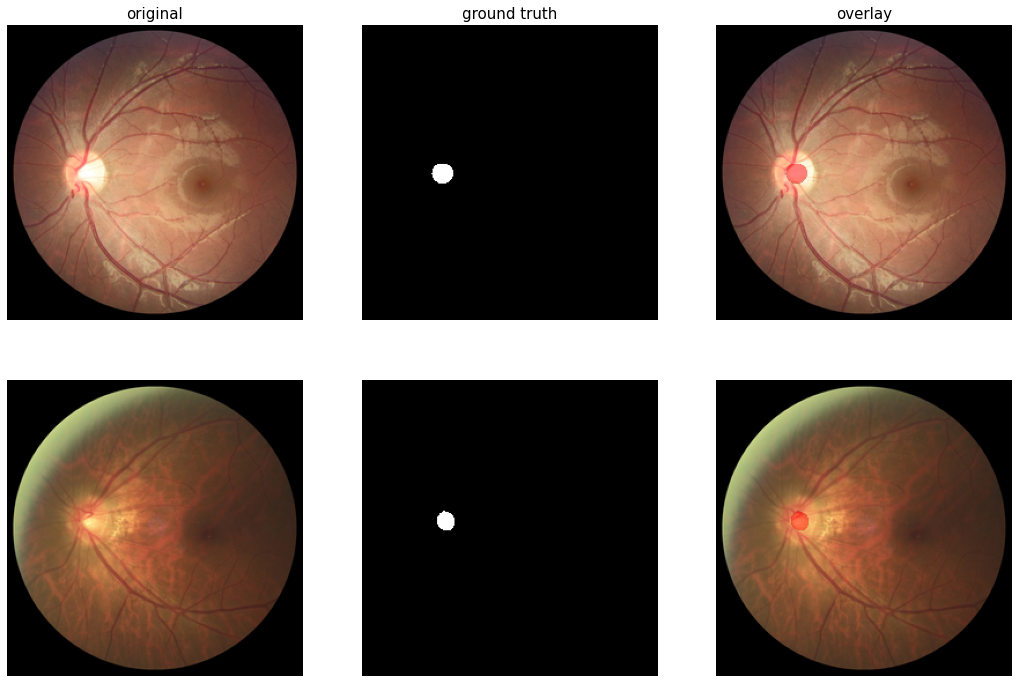

In [ ]:
plot_imgs(org_imgs=x, mask_imgs=y, nm_img_to_plot=2, figsize=6)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def get_augmented(
    X_train, 
    Y_train, 
    X_val=None,
    Y_val=None,
    batch_size=16, 
    seed=0, 
    data_gen_args = dict(
        rotation_range=10.,
        #width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=5,
        #zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    )):


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
        Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)
        
        return train_generator, val_generator
    else:
        return train_generator

In [ ]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.01,
        zoom_range=(0.8, 1.2),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval=0.0
    ))

In [ ]:
sample_batch = next(train_gen)
xx, yy = sample_batch

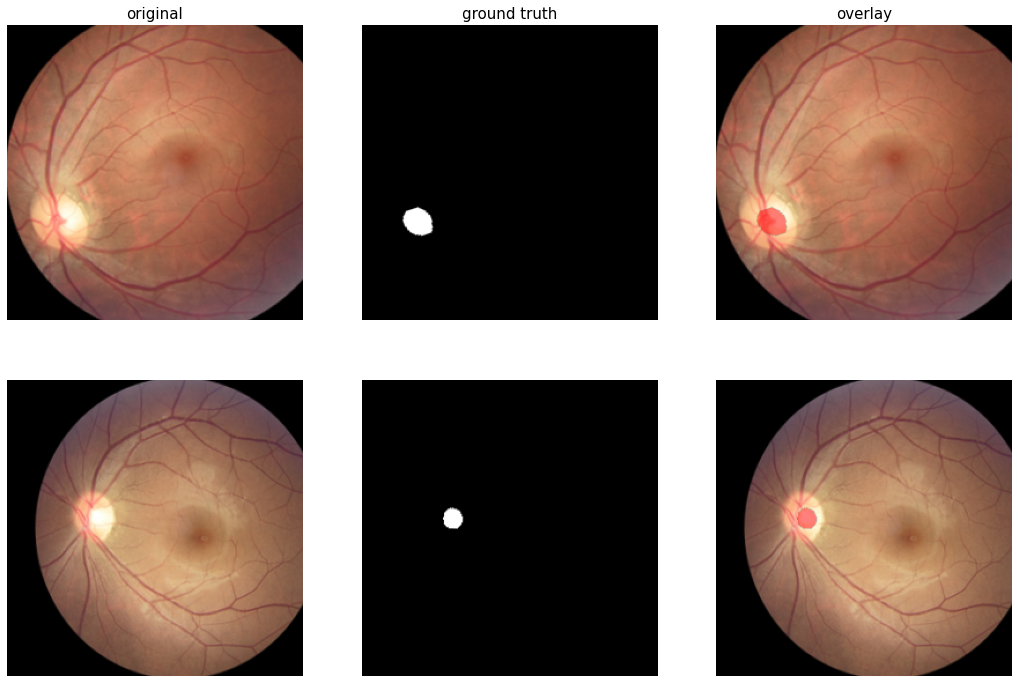

In [ ]:
plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, average

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate

def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)

def conv2d_block(
    inputs, 
    use_batch_norm=True, 
    dropout=0.3, 
    filters=16, 
    kernel_size=(3,3), 
    activation='relu', 
    kernel_initializer='he_normal', 
    padding='same'):
    
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding) (c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c

def unet_model(
    input_shape,
    num_classes=1,
    use_batch_norm=True, 
    upsample_mode='deconv', # 'deconv' or 'simple' 
    use_dropout_on_upsampling=False, 
    dropout=0.3, 
    dropout_change_per_layer=0.0,
    filters=16,
    num_layers=4,
    output_activation='sigmoid'): # 'sigmoid' or 'softmax'
    
    if upsample_mode=='deconv':
        upsample=upsample_conv
    else:
        upsample=upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    x = inputs   

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
        down_layers.append(x)
        x = MaxPooling2D((2, 2)) (x)
        dropout += dropout_change_per_layer
        filters = filters*2 # double the number of filters with each layer

    x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):        
        filters //= 2 # decreasing number of filters with each layer 
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding='same') (x)
        x = concatenate([x, conv])
        x = conv2d_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm, dropout=dropout)
    
    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
input_shape = x_train[0].shape

In [ ]:
modelc = unet_model(
    input_shape,
    num_classes=1,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid'
)

In [ ]:
print(modelc.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256, 256, 64) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf


def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

    
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    jac = (intersection + 1.) / (union - intersection + 1.)
    return K.mean(jac)


def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y


def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
modelc.compile(
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou_thresholded]
)

In [ ]:
history = modelc.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=20,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 12s 98ms/step - loss: 0.3300 - dice_coef: 0.1185 - iou_thresholded: 0.1479 - val_loss: 0.0358 - val_dice_coef: 0.2934 - val_iou_thresholded: 0.2312
Epoch 2/20
100/100 [==============================] - 9s 93ms/step - loss: 0.0066 - dice_coef: 0.5486 - iou_thresholded: 0.4380 - val_loss: 0.0571 - val_dice_coef: 0.3199 - val_iou_thresholded: 0.2115
Epoch 3/20
100/100 [==============================] - 9s 93ms/step - loss: 0.0075 - dice_coef: 0.5797 - iou_thresholded: 0.4547 - val_loss: 0.0101 - val_dice_coef: 0.5975 - val_iou_thresholded: 0.4665
Epoch 4/20
100/100 [==============================] - 9s 94ms/step - loss: 0.0068 - dice_coef: 0.5896 - iou_thresholded: 0.4796 - val_loss: 0.0118 - val_dice_coef: 0.5521 - val_iou_thresholded: 0.4249
Epoch 5/20
100/100 [==============================] - 9s 94ms/step - loss: 0.0059 - dice_coef: 0.6303 - iou_thresholded: 0.5371 - val_loss: 0.0058 - val_dice_coef: 0.6258 - val_iou_thresholded: 0

In [ ]:
y_pred = modelc.predict(x_val)

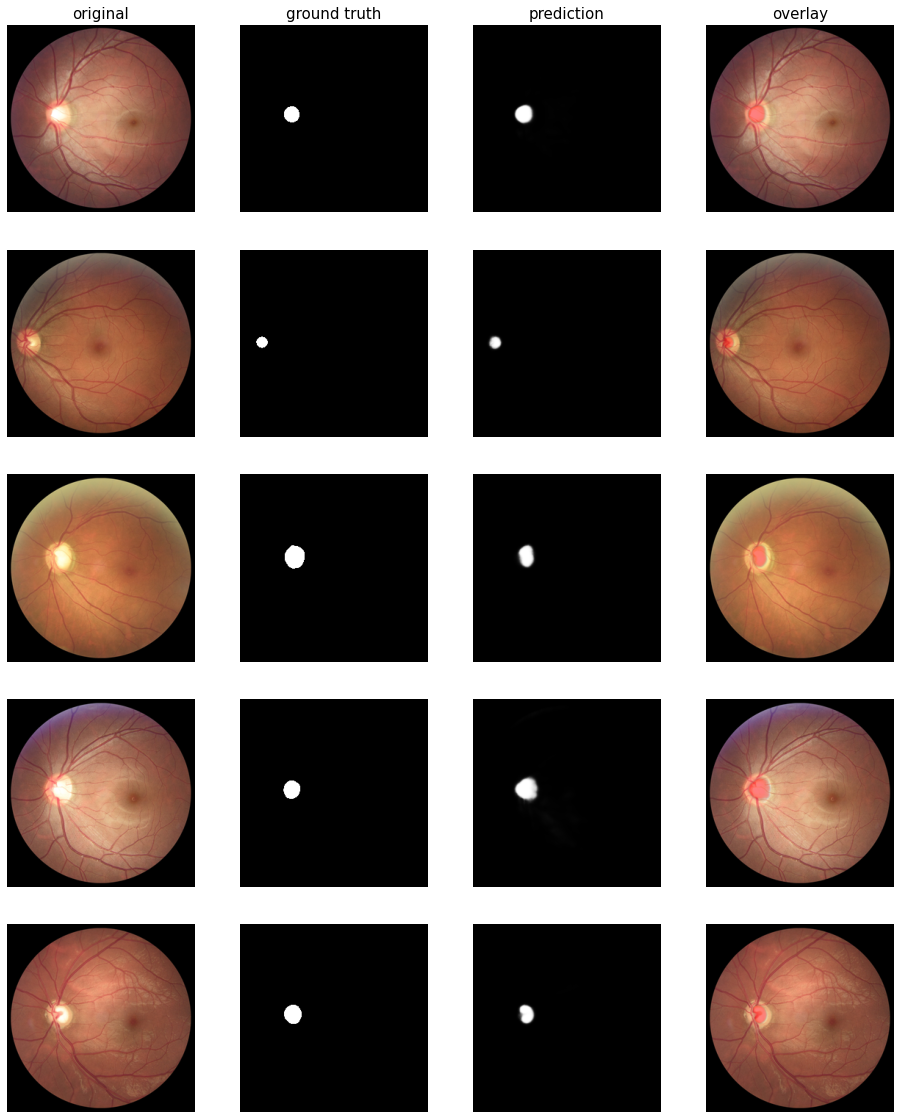

In [ ]:
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=5)

In [ ]:
yp = modelc.predict(x=x_val, batch_size=4, verbose=1)
yp = np.round(yp,0)
yp = np.squeeze(yp)

50/50 [==============================] - 2s 39ms/step


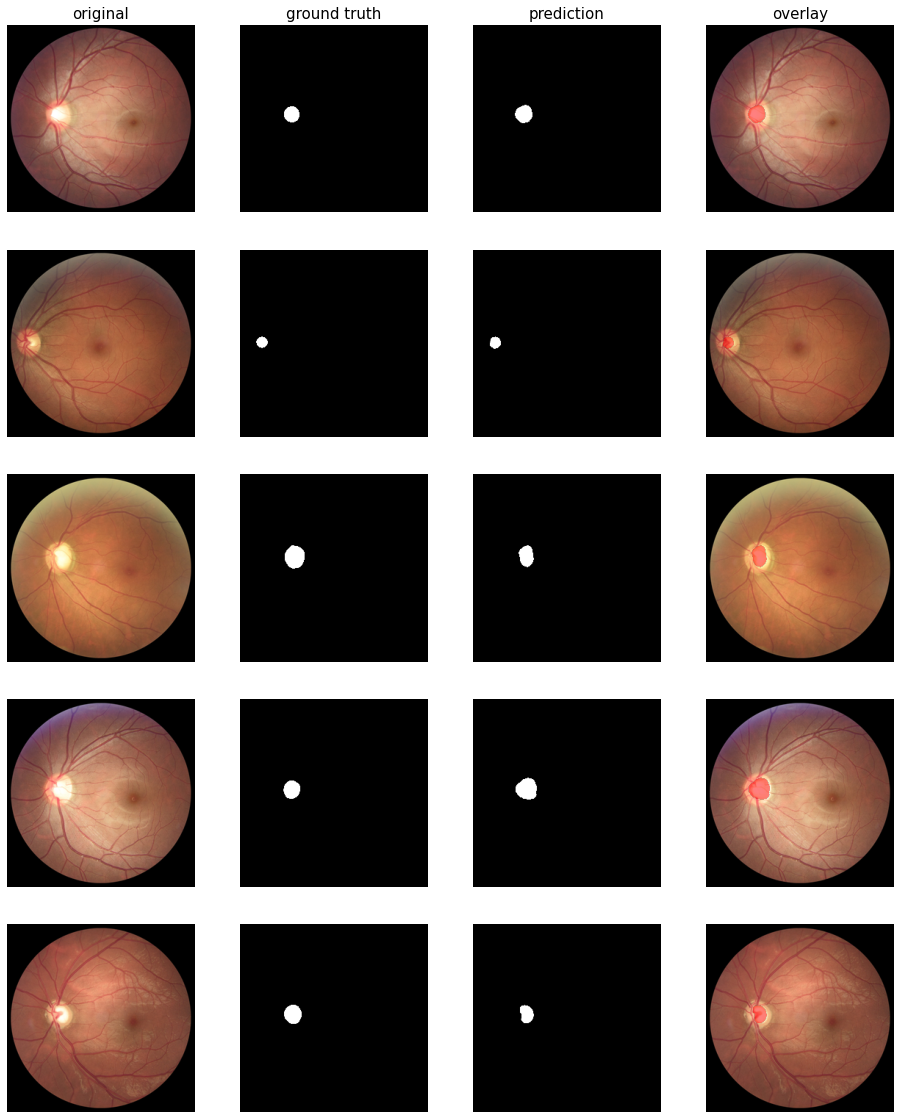

In [ ]:
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=yp, nm_img_to_plot=5)

In [ ]:
y_pred = modelc.predict(x_test)
y_pred_img = np.squeeze(y_pred)

In [ ]:
def img(i):
  plt.figure(figsize=(20,20))

  plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


  plt.subplot(3,3,1)
  plt.title("original",size=25)
  plt.imshow(x_test[i])
  plt.axis('off')
  


  plt.subplot(3,3,2)
  plt.title("prediction",size=25)
  plt.imshow(y_pred_img[i],cmap='gray')
  plt.axis('off')


  


  plt.subplot(3,3,3)
  plt.title("overlay",size=25)
  plt.imshow(x_test[i], cmap=get_cmap(x_test))
  plt.imshow(mask_to_red(zero_pad_mask(y_pred_img[i], desired_size=256)), cmap=get_cmap(y_pred_img), alpha=0.5)
  plt.axis('off')
  



  #plt.savefig('predict_img_siri/{0}.jpg'.format(b[i]))

In [ ]:
for i in range(len(x_test)):
  img(i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
preds_test = modelc.predict(x_test, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)
preds_test=np.squeeze(preds_test)

2/2 [==============================] - 0s 323ms/step


In [ ]:
def img(i):
  plt.figure(figsize=(20,20))

  plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


  plt.subplot(3,3,1)
  plt.title("original",size=25)
  plt.imshow(x_test[i])
  plt.axis('off')
  


  plt.subplot(3,3,2)
  plt.title("prediction",size=25)
  plt.imshow(preds_test[i],cmap='gray')
  plt.axis('off')


  


  plt.subplot(3,3,3)
  plt.title("overlay",size=25)
  plt.imshow(x_test[i], cmap=get_cmap(x_test))
  plt.imshow(mask_to_red(zero_pad_mask(preds_test[i], desired_size=256)), cmap=get_cmap(y_pred_img), alpha=0.5)
  plt.axis('off')
  



  #plt.savefig('predict_img_siri/{0}.jpg'.format(b[i]))

In [ ]:
for i in range(len(x_test)):
  img(i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_pred_disc = model.predict(x_test)
y_pred_disc = np.squeeze(y_pred_disc)

y_pred_cup = modelc.predict(x_test)
y_pred_cup = np.squeeze(y_pred_cup)

In [ ]:
def img(i):
  plt.figure(figsize=(20,20))

  plt.subplots_adjust(wspace = 0.4, hspace= 0.4)


  plt.subplot(3,5,1)
  plt.title("original",size=25)
  plt.imshow(x_test[i])
  #plt.axis('off')
  


  plt.subplot(3,5,2)
  plt.title("disc",size=25)
  plt.imshow(y_pred_disc[i],cmap='gray')
  #plt.axis('off')

  plt.subplot(3,5,3)
  plt.title("overlay_disc",size=25)
  plt.imshow(x_test[i], cmap=get_cmap(x_test))
  plt.imshow(mask_to_red(zero_pad_mask(y_pred_disc[i], desired_size=256)), cmap=get_cmap(y_pred_img), alpha=0.5)
  #plt.axis('off')


  plt.subplot(3,5,4)
  plt.title("cup",size=25)
  plt.imshow(y_pred_cup[i],cmap='gray')
  #plt.axis('off')


  

  plt.subplot(3,5,5)
  plt.title("overlay_cup",size=25)
  plt.imshow(x_test[i], cmap=get_cmap(x_test))
  plt.imshow(mask_to_red(zero_pad_mask(y_pred_cup[i], desired_size=256)), cmap=get_cmap(y_pred_img), alpha=0.5)
  #plt.axis('off')
  



  plt.savefig('Optic_disc_cup/{0}.jpg'.format(b[i]))

In [ ]:
for i in range(len(x_test)):
  img(i)

Output hidden; open in https://colab.research.google.com to view.